For the meetup on Dec 5, 2018 this is the main python notebook. To use all the functions you will need to obtain your own text analytics subsription key for Azure (free for up to 5000 calls per month) and update this code for where ever you decide to store the text filings. Note the using the entity detection is an option and can be replaced or ignored as no other functions depend upon it. 
A number of ideas for this come out of the book "Text Analytics with Python" by Dipanjan Sarkar publihed by Apress. This is a busy notebook and needs refactoring, but it does illustrate the things discusssed in the meetup.

In [459]:
import sys
import pandas as pd
import nltk
import io
import string
import requests
import time
from textblob import TextBlob 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
import matplotlib.pyplot as plt


C:\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [309]:
%matplotlib inline

In [310]:
def getents(segment): #segment is a string of text - representing a coherent chunk of a document
    baseuri   = 'https://westus2.api.cognitive.microsoft.com/text/analytics/v2.0'
    entapi    = baseuri + '/entities'
    headers   = {'Content-Type': 'application/json', 'Ocp-Apim-Subscription-Key': 'yourkey'}
    
    segtogo ={"documents": [
    {
      "language": "en",
      "id": "1",
      "text": segment 
      }
      ]
    }
    try:
        response  = requests.post(entapi,headers=headers,json=segtogo)
        resp      = response.json()
        names =  [ent['name'] for ent in resp['documents'][0]['entities'] ]
    except Exception as exc:
        print("Exceptin in getents:",exc)
        pass
        return []
    return names

In [557]:
nltk.download('stopwords')
stopw = set(nltk.corpus.stopwords.words('english'))
morestopw = ['0092','0093','0094','0095','2012','2013','2014','2015','2016','2017','2018','years','yearend','yearended','cash','report' \
'part','item','table','fiscal','ended','year','financial','vice','president','statements','annual','form', \
'corporation','item1','item1a','item7','item7a','may','due','investor','inc.','sec','report','1a','7a', \
'2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','part','1','7'] 
stopw.update(morestopw)

keepset = ('ai','io','up','fb')

punks = set(string.punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiwillia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [558]:
def display_features(feats,featnames):
    df=pd.DataFrame(data=feats,columns=featnames,index=feats)
    print(df.describe())

In [559]:
def filtodoc(afile):
        ttokfs   = []
        tsents   = []
        cleandoc = []
        print('The file to convert is ',afile)
        afile    = "1031/"+afile
        with io.open(afile,'r',encoding='utf-8-sig',errors='ignore') as f:
            allines=f.read()    
        ttoks   = nltk.tokenize.word_tokenize(allines)
        tsents  = nltk.tokenize.sent_tokenize(allines)
                                               #filter out tokens of low value
        ttoksf  = [word.lower() for word in ttoks if word.lower() not in stopw and word.lower() not in punks and \
                       (len(word.lower()) > 2 or word.lower() in keepset)]
        #lemmatize the tokens 12/4/18
        lemmat  = WordNetLemmatizer()
        ttoksf  = [lemmat.lemmatize(t,pos='v') for t in ttoksf] #v=verbs this can reduce features by 10 to 20%
        
        freqd   = nltk.FreqDist(ttoksf)
        bgrams  = nltk.FreqDist(nltk.bigrams(ttoksf))
        tgrams  = nltk.FreqDist(nltk.trigrams(ttoksf))
        bdf     = pd.DataFrame(bgrams.most_common(10))
        tdf     = pd.DataFrame(tgrams.most_common(10))
        print('Simple summary stats for ', afile)
        print("\t Sentence count is ",len(tsents))
        print('\t Ten most common words ',freqd.most_common(10))
        print(bdf.describe,tdf.describe)
        print('\t ************* \n\n')
        cleandoc = [' '.join(ttoksf)]          
        
        f.close()
        return cleandoc #ttoksf   #these are still token lists and need to be cleaned and then returned as doc of strings
                        #should return cleandoc now instead of the ttoksf 12/3/18 11:20AM
    

In [560]:
def buildvectorizers(thecorpus):  #the corpus is a list of documents where each document is cleaned but word order maintained
    print('thecorpus doccount is ',len(thecorpus))
    cvec            = CountVectorizer(min_df=2)
    ccounts         = cvec.fit_transform(thecorpus)
    #print('ccounts shape',ccounts.shape)
    ctfv            = TfidfVectorizer(min_df=2)
    ctfid           = ctfv.fit_transform(thecorpus)

    csklearn_tfid   = TfidfVectorizer(norm='l2',min_df=0.2, max_df=0.8, use_idf=True, smooth_idf=False, stop_words=stopw, \
                                sublinear_tf=True,ngram_range=(1,1))
    csklearn_rep    = csklearn_tfid.fit_transform(thecorpus)
    cskarray        = csklearn_rep.toarray()
    cfeats          = csklearn_tfid.get_feature_names()              # same as CountVectorizer
    mydictokens     = [nltk.word_tokenize(doc) for doc in thecorpus] #need for topic analysis downstream
    dictionary      = corpora.Dictionary(mydictokens)                #need fot topic analysis downstream
    
                                                        #print("Some TFID Features",cfeats[50:70],'\n')
                                                        #print("TFID entry for ",cfeats[57],  ' is ',cskarray[0:,57].tolist())
    return cfeats,csklearn_rep,csklearn_tfid,dictionary #return features names and the xformrep of the features and the TFID

In [592]:
fils =['GOOG2015Item 1A','GOOG2016Item 1A','GOOG2017Item 1A']
msfils1 =['MSFT2012Item 1','MSFT2013Item 1','MSFT2014Item 1','MSFT2015Item 1','MSFT2016Item 1','MSFT2014Item 1A', \
         'MSFT2015Item 1A', 'MSFT2016Item 1A']

ggfils1=['GOOG2015Item 1','GOOG2016Item 1','GOOG2017Item 1','GOOG2015Item 1A', 'GOOG2016Item 1A','GOOG2017Item 1A']

mixfils=['GOOG2015Item 1A','GOOG2016Item 1A','GOOG2017Item 1A','MSFT2015Item 1', 'MSFT2016Item 1','MSFT2017Item 1A']

verymix=['GOOG2016Item 1A','MSFT2015Item 1','AMZN2015Item 7','FB2016Item 1','IBM2017Item 7A','satya.txt']

fildir  = "1031/"
fil  = fildir+ msfils1[4]
print(fil)

fils=msfils1 #blast thru msft files
fils=mixfils #mix of msft and google 
fils=verymix


1031/MSFT2016Item 1


In [593]:
#take in list of files for covnert them into a corpus list of tokenized documents ready for text analytics
def buildcorpus(infiles):
    doctrack = 0
    if not isinstance(infiles,list):
        print(infiles," is not a list but appears to be ",type(infiles))
        return []
    else:
        #build the corpus
        print('processing files: ',infiles)
        corpus=[]
        for afil in infiles:
            print('processing ',afil)
            adoc             = []
            adoc             = filtodoc(afil)
            corpus.extend(adoc)
        return corpus

In [594]:
bc = buildcorpus(fils)
for d in bc:
    #print(d)
    print('------------------------*********************************-------------------------')
    


processing files:  ['GOOG2016Item 1A', 'MSFT2015Item 1', 'AMZN2015Item 7', 'FB2016Item 1', 'IBM2017Item 7A', 'satya.txt']
processing  GOOG2016Item 1A
The file to convert is  GOOG2016Item 1A
Simple summary stats for  1031/GOOG2016Item 1A
	 Sentence count is  341
	 Ten most common words  [('could', 107), ('result', 98), ('products', 93), ('service', 88), ('business', 67), ('stock', 49), ('users', 45), ('include', 43), ('operate', 39), ('new', 37)]
<bound method NDFrame.describe of                           0   1
0       (products, service)  63
1         (operate, result)  23
2  (intellectual, property)  22
3       (adversely, affect)  18
4          (capital, stock)  18
5          (class, capital)  14
6        (could, adversely)  13
7           (could, result)  12
8           (common, stock)  12
9           (class, common)  12> <bound method NDFrame.describe of                                    0   1
0            (class, capital, stock)  14
1             (class, common, stock)  12
2     

In [595]:

#call the buildvectorizer and get back countvectoizer features, a xformrep, and the tfid model
cfeats, ctfidrep, ctfidmodel,cdictionary = buildvectorizers(bc)
ctfarray = ctfidrep.toarray()
tfeats   = ctfidmodel.get_feature_names()
print(type(cdictionary))

print('features returned is ',len(cfeats),' and', len(tfeats), ' array len (#of documents) returned is ', len(ctfarray))
print('slice of 20 features ', cfeats[40:59])
print("values of the 20     ", ctfarray[0][40:59])

testword='algorithmic'
if testword in tfeats: #dump tfid vals for a given word across the documents
    print(testword,' tfid values are: ', ctfarray[0:,tfeats.index(testword)].tolist())


thecorpus doccount is  6


C:\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


<class 'gensim.corpora.dictionary.Dictionary'>
features returned is  1181  and 1181  array len (#of documents) returned is  6
slice of 20 features  ['adequate', 'adjustments', 'administrative', 'adopt', 'adoption', 'ads', 'advance', 'advantage', 'adversely', 'advertise', 'advertisements', 'advertisers', 'affairs', 'affect', 'affiliate', 'african', 'age', 'agencies', 'aggregate']
values of the 20      [0.03625833 0.02141475 0.01727729 0.01727729 0.03625833 0.0532044
 0.01434171 0.03422354 0.09118608 0.05579458 0.03625833 0.06159265
 0.01727729 0.06160964 0.         0.         0.         0.02925299
 0.        ]


In [602]:
#topic analysis - a simple attempt to find clusters of topics by probabalistic sampling of the word distribution
#need a corpus, dictionary and a tfidf model to use latent semantic indexing as a topic analysis
#need a dictionary for the vocabulary that is the second argument id2word

total_topics = 4 #start with a reasonable guess
#cdictionary - this is how cdictionary was built...corpora.Dictionary([nltk.word_tokenize(doc) for doc in docs])
#need the dictonary tokens from the cleaned up doc collection - bc which was created by buildcorpus call earlier
mydictokens  = [nltk.word_tokenize(doc) for doc in bc] 
ccorpus      = [cdictionary.doc2bow(text) for text in mydictokens]
ctfidf       = models.TfidfModel(ccorpus) 
corpus_tfidf = ctfidf[ccorpus]

lsi          = models.LsiModel(corpus_tfidf, id2word=cdictionary,  num_topics=total_topics)
print('******* Try LSI Latent Semantic Index topic analysis ******')
for index,topic in lsi.print_topics(total_topics):
    print('LSI Topic #',str(index+1))
    print('\t Topic\n',topic)
print('---------------------------------------------------------------------------------------')
print('******* Try LDA latent dirichlet allocation for topics    ******')
lda          = models.LdaModel(corpus_tfidf,id2word=cdictionary,iterations=1000,num_topics=total_topics)
for index,topic in lda.print_topics(total_topics):
    print('LDA Topic #',str(index+1))
    print('\t Topic\n',topic)
#lda.print_topics()

#print_topics_gensim(lda_gensim,total_topics,weight_threshold=0.001,num_terms=7)

******* Try LSI Latent Semantic Index topic analysis ******
LSI Topic # 1
	 Topic
 -0.212*"microsoft" + -0.156*"tax" + -0.139*"windows" + -0.123*"million" + -0.119*"service" + -0.117*"solutions" + -0.109*"products" + -0.103*"primarily" + -0.097*"foreign" + -0.093*"facebook"
LSI Topic # 2
	 Topic
 -0.313*"microsoft" + -0.175*"windows" + 0.164*"tax" + -0.152*"thank" + -0.144*"think" + -0.141*"solutions" + -0.129*"'re" + 0.124*"quantitative" + -0.110*"cloud" + -0.109*"'ll"
LSI Topic # 3
	 Topic
 0.458*"quantitative" + 0.279*"disclosures" + 0.276*"qualitative" + 0.229*"herein" + 0.229*"disagreements" + 0.229*"accountants" + 0.229*"page74" + 0.229*"issuer" + 0.229*"title" + 0.171*"equity"
LSI Topic # 4
	 Topic
 0.201*"facebook" + -0.197*"million" + 0.179*"marketers" + -0.178*"tax" + -0.148*"net" + 0.146*"instagram" + -0.137*"primarily" + -0.120*"flow" + 0.110*"offices" + 0.110*"oculus"
---------------------------------------------------------------------------------------
******* Try LDA la

In [599]:
#use linear alg to compare document vectors - we have several docs and a sparse vector
testword    = 'revenues' #override here - testword has been set above
corpdf      = pd.DataFrame(data=ctfarray,columns=tfeats) 
corpdf[testword]
corpdfboth  =  (corpdf.loc[0] > 0.0) & (corpdf.loc[1] > 0.0)  #intersection
print(corpdfboth.describe())
inboth      = corpdfboth[corpdfboth == True] #results in a pandas series
notboth     = corpdfboth[corpdfboth == False]
print('inboth count',len(inboth),'\n\t',inboth[20:40])
print('notbothcount',len(notboth),'\n\t',notboth[20:40])
#could also use count vectorizer where it really becomes integer based counting since the values are just counts per doc
#now let's try comparing via math the first two of our three documents
print('comparing two docs by their TFID vectors - closer to 1.0 is more similar ', corpdf.loc[0].dot(corpdf.loc[4])) #try 5

count      1181
unique        2
top       False
freq        811
dtype: object
inboth count 370 
	 alter            True
alternative      True
alternatives     True
although         True
among            True
amount           True
announcements    True
another          True
apply            True
approximately    True
around           True
array            True
aspects          True
assessment       True
associate        True
assurance        True
attract          True
authorize        True
availability     True
based            True
dtype: bool
notbothcount 811 
	 accelerate        False
accept            False
accessible        False
accessories       False
accuracy          False
achieve           False
acquisitions      False
action            False
active            False
actively          False
activity          False
actual            False
add               False
additionally      False
adequate          False
adjustments       False
administrative    False
adversely         Fals

In [498]:
with io.open(fil,'r',encoding='utf-8-sig',errors='ignore') as f:
    allines=f.read()

ntoks   = nltk.tokenize.word_tokenize(allines)
nsents  = nltk.tokenize.sent_tokenize(allines)
#bring nsents back to one big text doc
ntext   = nltk.Text(ntoks) #generates a list of tokens
rawtext = nltk.Text(allines)

ntexto  = ntext #keep originak around

ntext.collocations(num=10)

Vice President; Executive Vice; operating system; Software Assurance;
volume licensing; cloud services; perpetual licenses; Office 365;
Premium Subscriptions; Select Plus


In [499]:
cololist = [" ".join(el) for el in list(ntext._collocations)]

devconc  = ntext.concordance('devices',width=120)
#devconlist = [''.join(el) for el in list(ntext.tokens)]
#print('-------dev concordance---',devconlist)
servconc = ntext.concordance('competition',width=120)

print('similar to devices\t\n')
ntext.similar('devices\n\n')
print('-----------end concodance-----------------')
#cleau up ntext and is it now a lits of tokens ntextf = filtered
ntextf      = [word.lower() for word in ntext if word.lower() not in stopw and word.lower() not in punks and (len(word.lower()) > 2 or word.lower() in keepset)]
lemmatizer  = WordNetLemmatizer()
lems        = [lemmatizer.lemmatize(t,pos='v') for t in ntextf] #v=verbs 
print("lemscountis: ", len(lems),"first10 is: ",lems[0:90])

Displaying 25 of 49 matches:
ience with technology increasingly spans a multitude of devices and becomes more natural and multi-sensory with voice ,
nd acts on the users behalf , and user experiences span devices with a users available data and information . We contin
port a wide range of software products , services , and devices that deliver new opportunities , greater convenience , 
nd developers . We also design , manufacture , and sell devices , including PCs , tablets , gaming and entertainment co
, gaming and entertainment consoles , other intelligent devices , and related accessories , that integrate with our clo
formation products and services that span platforms and devices . Productivity is our first and foremost objective , to
rustworthy . We offer our services across platforms and devices outside our own . As people move from device to device 
ility and scale they want . AI will be pervasive across devices , applications , and infrastructure to drive insights a
merging app

In [500]:
fulltext    = [' '.join(ntextf)]
fulltextlem = [' '.join(lems)] #11/27 use lemmatization 
fulltext    = fulltextlem

In [501]:
print(type(fulltext))

<class 'list'>


# filtered tokens  4885  # unfiltered tokens 8996
# of sentences  338


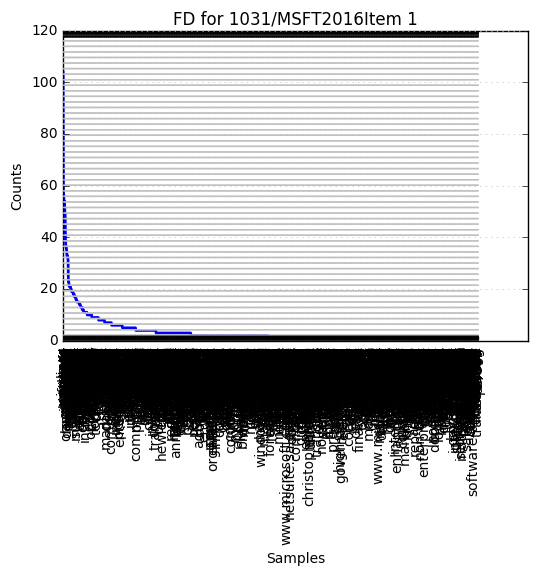

<bound method FreqDist.N of FreqDist({'services': 104, 'products': 58, 'windows': 56, 'software': 54, 'microsoft': 54, 'business': 54, 'cloud': 49, 'devices': 49, 'customers': 39, 'including': 37, ...})>
0.001842374616171955
[('services', 104), ('products', 58), ('windows', 56), ('software', 54), ('microsoft', 54), ('business', 54), ('cloud', 49), ('devices', 49), ('customers', 39), ('including', 37)] 




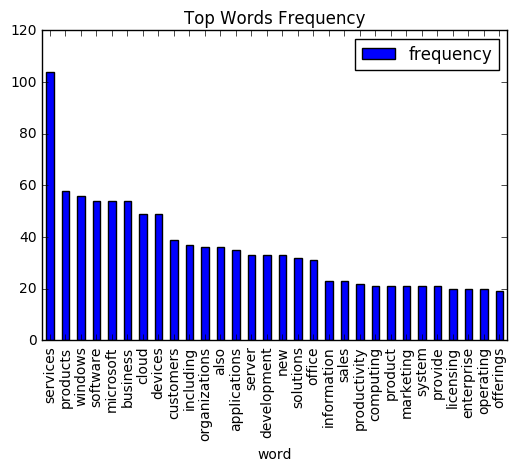

In [502]:
print('# filtered tokens ',len(ntextf),' # unfiltered tokens',len(ntoks))
print('# of sentences ',len(nsents))
#prepped for furthe analysis
#print('ntextf ',ntextf[0:9])
freqd   = nltk.FreqDist(ntextf)

freqd.plot(title = "FD for "+fil)
bgrams  = nltk.FreqDist(nltk.bigrams(ntextf))
tgrams  = nltk.FreqDist(nltk.trigrams(ntextf))
print(freqd.N)
print(freqd.freq('competition'))
print(freqd.most_common(10),'\n\n')
fdc     = freqd.most_common(30)
pdf     = pd.DataFrame(data=fdc,columns=['word','frequency'])
pdf.plot(kind='bar',x='word',y='frequency',title='Top Words Frequency')


In [503]:
fstr            = freqd.pformat(maxlen=10)
print('top 10 freq:',fstr,'\n')
print('\tbigrams \t',bgrams.most_common(10))
tgramelem       = tgrams.most_common(10)
tgentry         = tgramelem[0]
print(type(tgentry),'\n is ', tgentry[0],' occurs ',tgentry[1])
dftrig          = pd.DataFrame(tgramelem)
print(dftrig.describe)

top 10 freq: FreqDist({'services': 104, 'products': 58, 'windows': 56, 'software': 54, 'microsoft': 54, 'business': 54, 'cloud': 49, 'devices': 49, 'customers': 39, 'including': 37, ...}) 

	bigrams 	 [(('products', 'services'), 28), (('cloud', 'services'), 17), (('operating', 'system'), 13), (('research', 'development'), 12), (('server', 'products'), 10), (('volume', 'licensing'), 10), (('software', 'assurance'), 10), (('office', '365'), 9), (('personal', 'computing'), 8), (('small', 'medium'), 8)]
<class 'tuple'> 
 is  ('windows', 'operating', 'system')  occurs  7
<bound method NDFrame.describe of                                      0  1
0         (windows, operating, system)  7
1          (revenue, mainly, affected)  6
2      (purchase, perpetual, licenses)  6
3      (licenses, software, assurance)  5
4            (server, products, cloud)  5
5  (productivity, business, processes)  5
6          (products, cloud, services)  5
7       (small, medium, organizations)  4
8    (intellige

In [504]:
#we have a bunch of sentencies stored in nsents
sblob           = TextBlob(allines)
polarities      = [sentence.sentiment.polarity for sentence in sblob.sentences]
subjectivities  = [sentence.sentiment.subjectivity for sentence in sblob.sentences]
pseries         = pd.Series.data=polarities
pdsubj          = pd.DataFrame(data=subjectivities)
pdsent          = pd.DataFrame(data=polarities)

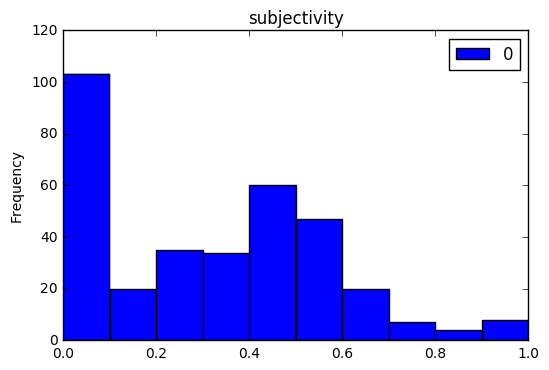

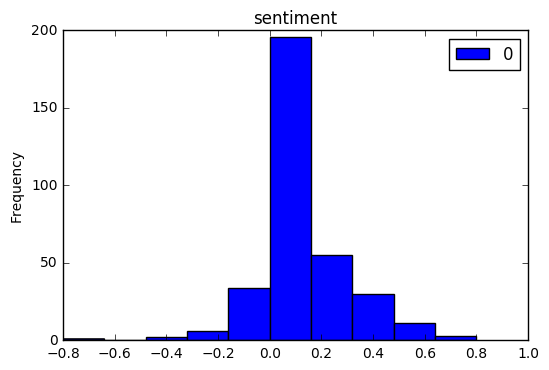

In [505]:
#pdsubj.boxplot(return_type='dict')
pdsubj.plot.hist(title='subjectivity')
pdsent.plot.hist(title='sentiment')

In [506]:
ents=[]
segl       = [asent for asent in sblob.sentences]
sweeps     = (len(segl))

In [507]:
startsweep = 0
endsweep   = startsweep + 9
tens       = int(sweeps/10)      #how many groups of 10 sentence blocks can be sent to the text analytics
remains    = sweeps%10      #remaining size of last blokc of sentences 
print("number of sentences to getents on: ",sweeps)

#streamline testibg and force tens to be smaller for this run
#tens=2
for i in range(tens):
    segout      = ''.join(str(aseg) for aseg in segl[startsweep:endsweep]) #         ]''.join(segl[1]) #+ ''.join(segl[2]) + ''.join(segl[3])
    ents.extend(getents(segout))
    startsweep  = startsweep + 10
    endsweep    = startsweep + 9
    time.sleep(1)
    print('completed sweeps: ',startsweep,'--',endsweep,' loopcount ',i)

entDF           = pd.DataFrame(data=ents)
entDS           = pd.Series(data=ents)
print("entities:\t",entDS.value_counts())

number of sentences to getents on:  338
completed sweeps:  10 -- 19  loopcount  0
completed sweeps:  20 -- 29  loopcount  1
completed sweeps:  30 -- 39  loopcount  2
completed sweeps:  40 -- 49  loopcount  3
completed sweeps:  50 -- 59  loopcount  4
completed sweeps:  60 -- 69  loopcount  5
completed sweeps:  70 -- 79  loopcount  6
completed sweeps:  80 -- 89  loopcount  7
completed sweeps:  90 -- 99  loopcount  8
completed sweeps:  100 -- 109  loopcount  9
completed sweeps:  110 -- 119  loopcount  10
completed sweeps:  120 -- 129  loopcount  11
completed sweeps:  130 -- 139  loopcount  12
completed sweeps:  140 -- 149  loopcount  13
completed sweeps:  150 -- 159  loopcount  14
completed sweeps:  160 -- 169  loopcount  15
completed sweeps:  170 -- 179  loopcount  16
completed sweeps:  180 -- 189  loopcount  17
completed sweeps:  190 -- 199  loopcount  18
completed sweeps:  200 -- 209  loopcount  19
completed sweeps:  210 -- 219  loopcount  20
completed sweeps:  220 -- 229  loopcount  2

In [535]:
count_vect = CountVectorizer(min_df=1)
tfidvec    = TfidfVectorizer(min_df=1)
tfid       = tfidvec.fit_transform(fulltext)

sklearn_tfidf           = TfidfVectorizer(norm='l2',min_df=0.2, use_idf=True, smooth_idf=False, stop_words=stopw, \
                                sublinear_tf=True,ngram_range=(1,1))
sklearn_representation  = sklearn_tfidf.fit_transform(fulltext)
skarray                 = sklearn_representation.toarray()
feats                   = sklearn_tfidf.get_feature_names() # same as CountVectorizer
print('#features is ',len(feats))
print("Some TFID Features",feats[50:70],'\n')
#with one doc this is trivial
print("TFID entry for ",feats[50],  ' is ',skarray[0:,50].tolist())
print("TFID entry for ",feats[175],  ' is ',skarray[0:,75].tolist())
print('skshape ', skarray.shape)
print('SK', skarray[0][50])
print('SK2',skarray[0:,50])

#features is  1201
Some TFID Features ['ads', 'advance', 'advantage', 'advertise', 'advertiser', 'advertisers', 'advise', 'advisors', 'affairs', 'affect', 'affiliate', 'africa', 'african', 'age', 'agencies', 'aggregate', 'agility', 'agreement', 'agreements', 'ai'] 

TFID entry for  ads  is  [0.02390444434939879]
TFID entry for  capabilities  is  [0.02390444434939879]
skshape  (1, 1201)
SK 0.02390444434939879
SK2 [0.02390444]


C:\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [536]:
df          = pd.DataFrame(sklearn_representation.toarray(),columns=feats)
#print(sklearn_representation.todense().round(4))
#print(df.loc[0:1])
print(df.describe())
features    = count_vect.fit_transform(fulltext)    
densefeat   = features.todense()
dfcv        = pd.DataFrame(features.toarray(),columns=count_vect.get_feature_names() )    
counts_rows,counts_cols = features.get_shape()
print('Word Counts:',counts_rows,counts_cols)
#print('counts first entry[0][0] ',features[0,0:counts_cols])                      #get all the flags for the first document for all words in vocabularly


            000  0billion        10        11        12       124        13  \
count  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
mean   0.046627  0.014118  0.029629  0.023904  0.023904  0.014118  0.014118   
std         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
min    0.046627  0.014118  0.029629  0.023904  0.023904  0.014118  0.014118   
25%    0.046627  0.014118  0.029629  0.023904  0.023904  0.014118  0.014118   
50%    0.046627  0.014118  0.029629  0.023904  0.023904  0.014118  0.014118   
75%    0.046627  0.014118  0.029629  0.023904  0.023904  0.014118  0.014118   
max    0.046627  0.014118  0.029629  0.023904  0.023904  0.014118  0.014118   

            190      1975      1984    ...      workers  workforce  workplace  \
count  1.000000  1.000000  1.000000    ...     1.000000   1.000000   1.000000   
mean   0.014118  0.014118  0.014118    ...     0.029629   0.014118   0.029629   
std         NaN       NaN       NaN    ...   

In [537]:
featnames   = count_vect.get_feature_names()
#print('feature locs for customer and xbox are :\n',featnames.index('customer'),'\t',featnames.index('xbox'))
print('initial feature names:\n',featnames[0:5],'\t',featnames[50:59])
#print(dfcv.loc[0])
print('---------------break-------------------')
print(features.get_shape())
display_features(features.todense(),featnames)

initial feature names:
 ['000', '0billion', '10', '11', '12'] 	 ['adopt', 'adoption', 'ads', 'advance', 'advantage', 'advertise', 'advertiser', 'advertisers', 'advise']
---------------break-------------------
(1, 1218)
        000  0billion   10   11   12  124   13  190  1975  1984  ...   \
count   1.0       1.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0   1.0  ...    
mean   10.0       1.0  3.0  2.0  2.0  1.0  1.0  1.0   1.0   1.0  ...    
std     NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  ...    
min    10.0       1.0  3.0  2.0  2.0  1.0  1.0  1.0   1.0   1.0  ...    
25%    10.0       1.0  3.0  2.0  2.0  1.0  1.0  1.0   1.0   1.0  ...    
50%    10.0       1.0  3.0  2.0  2.0  1.0  1.0  1.0   1.0   1.0  ...    
75%    10.0       1.0  3.0  2.0  2.0  1.0  1.0  1.0   1.0   1.0  ...    
max    10.0       1.0  3.0  2.0  2.0  1.0  1.0  1.0   1.0   1.0  ...    

       workforce  workplace  world  worlds  worldwide  worry  www  xbox  \
count        1.0        1.0    1.0     1.0      